In [1]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
import math
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from prototyping import *
from dtw import dtw
from numpy.linalg import norm
import os
plt.rcParams['figure.dpi'] = 100

In [2]:
def get_spectrogram(audio_arr):
    # Create BFT object and extract mel spectrogram
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=SAMPLE_RATE,
                     scale_type=SpectralFilterBankScaleType.MEL)

    spec_arr = bft_obj.bft(audio_arr)
    spec_arr = np.abs(spec_arr)
    return bft_obj, spec_arr

def show_spectrogram(audio_len: int, bft_obj, spec_arr, ax):
    img = fill_spec(spec_arr, axes=ax,
              x_coords=bft_obj.x_coords(audio_len),
              y_coords=bft_obj.y_coords(),
              x_axis='time', y_axis='log',
              title='Mel Spectrogram')
    fig.colorbar(img, ax=ax)


Target sample rate 22050
Generator sample rate 22050


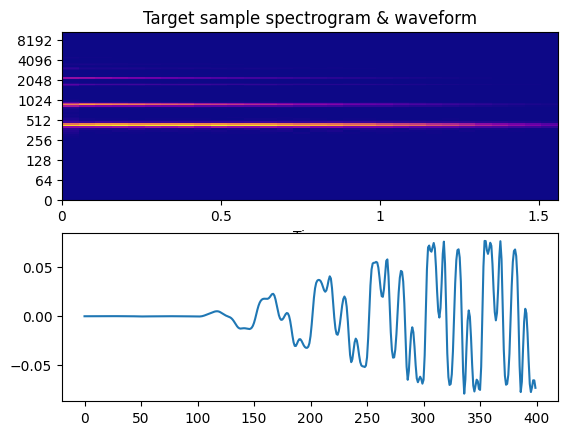

In [3]:
import librosa

fm_sample_data, fm_sample_sample_rate = librosa.load('./fm_sample.wav')
print("Target sample rate", fm_sample_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

bft_obj, spec_arr = get_spectrogram(fm_sample_data)
target_sample_bft, target_sampe_spec_arr = bft_obj, spec_arr

audio_len = fm_sample_data.shape[-1]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
img = fill_spec(spec_arr, axes=ax,
          x_coords=bft_obj.x_coords(audio_len),
          y_coords=bft_obj.y_coords(),
          x_axis='time', y_axis='log',
          title='Target sample spectrogram & waveform')

ax2.plot(fm_sample_data[:400])

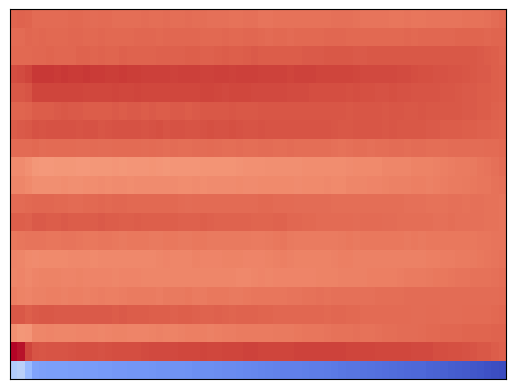

In [4]:
fm_sample_mfcc = librosa.feature.mfcc(y=fm_sample_data, sr=fm_sample_sample_rate)
librosa.display.specshow(fm_sample_mfcc)
Audio(data=fm_sample_data, rate=fm_sample_sample_rate)
# print(fm_sample_sample_rate)

New best score!
Normalized distance between the two sounds: 44271.32056121311
iteration 0


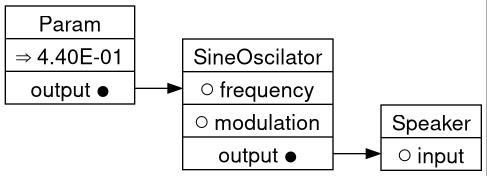

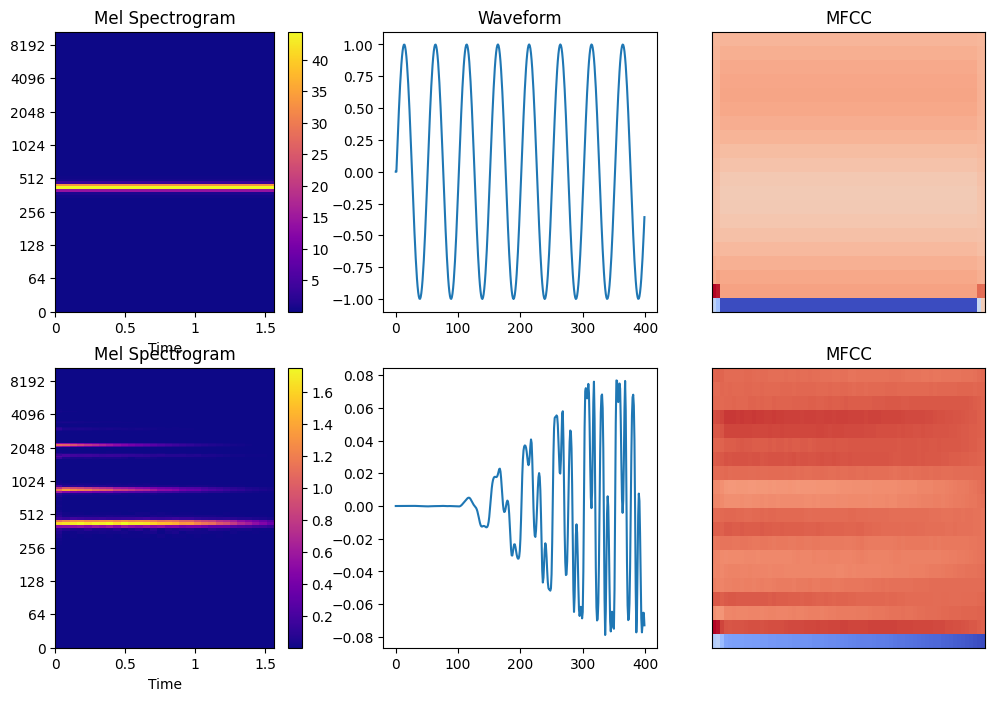

In [5]:
from itertools import count
from copy import deepcopy
from IPython.display import clear_output

start_graph = get_starting_graph()
current_graph = deepcopy(start_graph)
best_score = 10000000000

# for iteration_number in count():
for iteration_number in range(1):
    
    # Javascript(f"document.title = 'iteration {iteration_number}';")
    graph = deepcopy(current_graph)
    graph_not_modified = deepcopy(current_graph)
    
    nodes = [SineOscilator, Doubler, ADSR, Sum, Param]

    if iteration_number > 3:
        for _ in range(random.choice([5, 10, 20, 50, 100])):
            random.choice(
                [
                    add_random_node,
                    add_random_connection,
                    add_random_connection,
                    remove_random_connection,
                    randomize_random_param,
                    multiply_random_param_by_harmonic,
                    nudge_random_param,
                    randomize_random_param,
                    nudge_random_param                
                ]
            )(graph)
    g = graph

    audio_arr = np.zeros(len(fm_sample_data))

    for i in range(len(audio_arr)):
        audio_arr[i] = g.tick()
        # time.sleep(0.01)
        
    audio_arr /= max(audio_arr)
    
    try:
        generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
    except:
        # print("Cannot generate nfcc")
        continue
    dist, cost, acc_cost, path = dtw(fm_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
    dist -= len(graph.connections) - len(graph.nodes) / 3.0
    if dist <= best_score:
        # os.system("beep")
        clear_output()
    
        plt.rcParams['figure.figsize'] = [12, 8]
        print("New best score!")
        print('Normalized distance between the two sounds:', dist)

        current_graph = graph_not_modified
        best_score = dist
    
        print("iteration", iteration_number)
        display(Image(g.draw()))

        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=False, sharey=False)
        
        
        bft_obj, spec_arr = get_spectrogram(audio_arr)
        show_spectrogram(len(audio_arr), bft_obj, spec_arr, ax1)
        show_spectrogram(len(fm_sample_data), target_sample_bft, target_sampe_spec_arr, ax4)
        
            
        audio_len = audio_arr.shape[-1]

        ax3.set_title("MFCC")
        generated_sample_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
        librosa.display.specshow(generated_sample_mfcc, ax=ax3)
        
        ax6.set_title("MFCC")
        librosa.display.specshow(fm_sample_mfcc, ax=ax6)
        
        ax2.set_title("Waveform")
        ax2.plot(audio_arr[:400])
        ax5.plot(fm_sample_data[:400])
        display(Audio(data=audio_arr, rate=SAMPLE_RATE))
        display(Audio(data=fm_sample_data, rate=SAMPLE_RATE))
        plt.show()
        
        # break # warning
        # break
        # time.sleep(20)

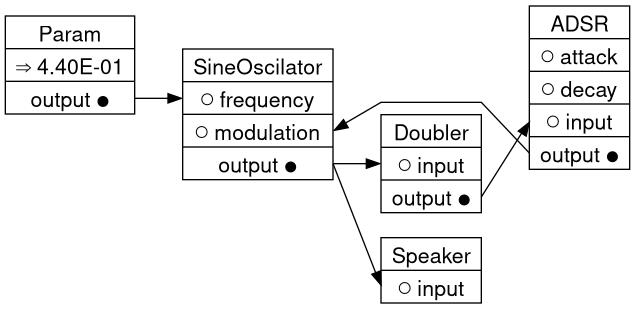

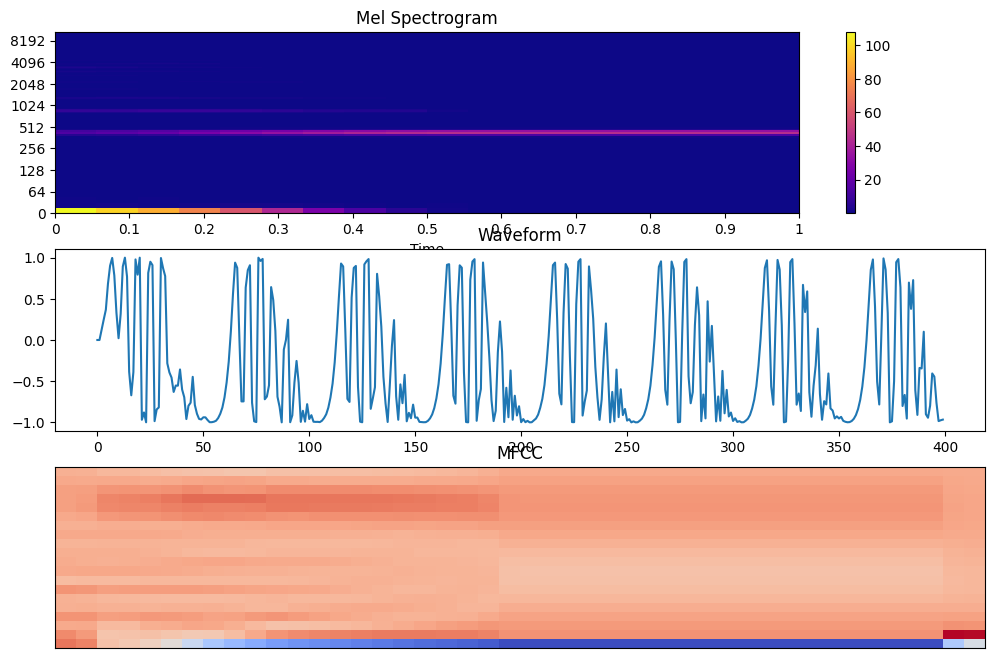

In [6]:
graph = get_starting_graph()

# add_adsr_between(graph, 1, 0)


def get_node_of_type(graph, node_type):
    for node_handle, node in graph.nodes.items():
        if isinstance(node, node_type):
            return node_handle

sine = get_node_of_type(graph, SineOscilator)
# sine = get_node_of_type(graph, SineOscilator)
doubler = graph.add_node(Doubler())
# graph.connections.pop(1)
graph.patch(sine, "output", doubler, "input")
adsr = graph.add_node(ADSR())
graph.patch(doubler, "output", adsr, "input")
graph.patch(adsr, "output", sine, "modulation")

graph.nodes[adsr].inputs.decay =   0.0001

# graph.patch
# graph.nodes[]
# randomize_random_param(graph)
# randomize_random_param(graph)
# randomize_random_param(graph)
# randomize_random_param(graph)

audio_arr = np.zeros(SAMPLE_RATE * 1)
for i in range(len(audio_arr)):
    audio_arr[i] = graph.tick()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)


bft_obj, spec_arr = get_spectrogram(audio_arr)
show_spectrogram(len(audio_arr), bft_obj, spec_arr, ax1)

# print(spec_arr.shape)
# print(audio_arr)

# audio_len = audio_arr.shape[-1]

ax3.set_title("MFCC")
generated_sample_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
librosa.display.specshow(generated_sample_mfcc, ax=ax3)

ax2.set_title("Waveform")
ax2.plot(audio_arr[:400])

# plt.show()
display(Image(graph.draw()))

display(Audio(data=audio_arr, rate=SAMPLE_RATE))
# display(Audio(data=fm_sample_data, rate=SAMPLE_RATE))
# plt.show()
# audio_arr

2 1 1 0
1 0 1 0
removing


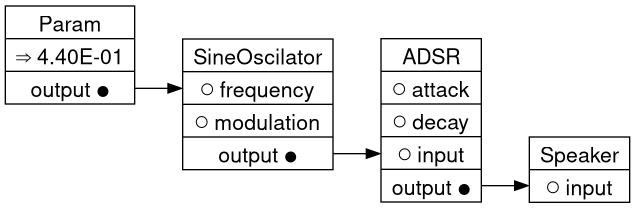

In [7]:
graph = get_starting_graph()


def add_adsr_between(graph: DspGraph, output_node: NodeId, input_node: NodeId) -> Optional[NodeId]:
    for connection in graph.connections:
        print(connection.from_node, connection.to_node, output_node, input_node)
        if connection.from_node == output_node and connection.to_node == input_node:
            print("removing")
            graph.connections.remove(connection)
            break
            
    new_adsr = graph.add_node(ADSR())
    graph.patch( output_node, "output", new_adsr, "input")
    graph.patch(new_adsr, "output", input_node, "input")
        
        
add_adsr_between(graph, 1, 0)

Image(graph.draw())

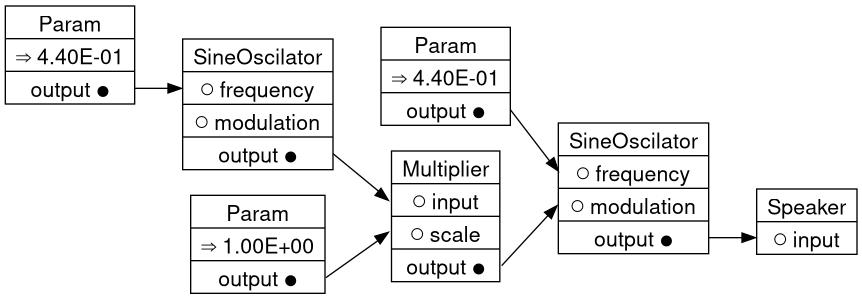

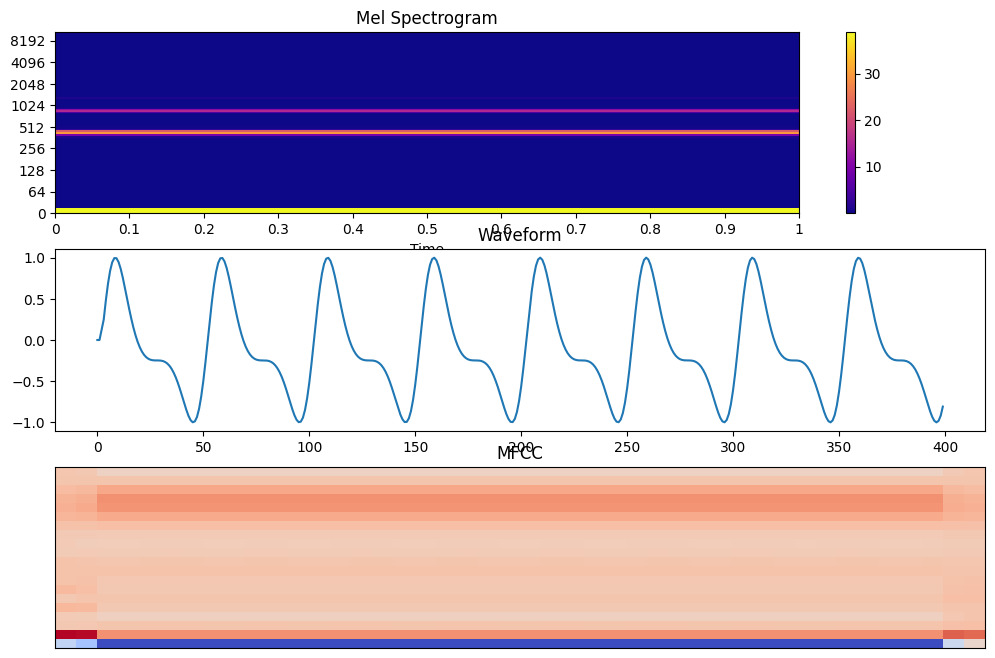

In [21]:
def make_simple_fm(mod_freq, mod_strength) -> DspGraph:
    graph = get_starting_graph()

    modulator = graph.add_node(SineOscilator())
    mod_mult = graph.add_node(Multiplier())

    _mod_freq = Param()
    _mod_scale = Param()
    _mod_scale.set_value(mod_strength)
    _mod_freq.set_value(mod_freq)
    
    mod_freq = graph.add_node(_mod_freq)
    mod_strength = graph.add_node(_mod_scale)

    graph.patch(mod_strength, "output", mod_mult, "scale")
    graph.patch(mod_freq, "output", modulator, "frequency")
    graph.patch(modulator, "output", mod_mult, "input")
    graph.patch(mod_mult, "output", 1, "modulation")

    return graph, mod_strength, mod_freq

graph, mod_strength, mod_freq = make_simple_fm(.440, 1.0)
Image(graph.draw())

audio_arr = np.zeros(SAMPLE_RATE * 1)
for i in range(len(audio_arr)):
    # graph.nodes[mod_strength].set_value( graph.nodes[mod_strength].get_value() + 0.0001 )
    # graph.nodes[mod_freq].set_value( graph.nodes[mod_freq].get_value() - 0.00001 )
    audio_arr[i] = graph.tick()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)


bft_obj, spec_arr = get_spectrogram(audio_arr)
show_spectrogram(len(audio_arr), bft_obj, spec_arr, ax1)

ax3.set_title("MFCC")
generated_sample_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
librosa.display.specshow(generated_sample_mfcc, ax=ax3)

ax2.set_title("Waveform")
ax2.plot(audio_arr[:400])

# plt.show()
display(Image(graph.draw()))

display(Audio(data=audio_arr, rate=SAMPLE_RATE))

target_sample = audio_arr
target_sample_mfcc = generated_sample_mfcc

In [34]:
plus_minus = 4
base = 440
mod_freqs = [ a/1000 for a in range(200, 800, 20) ]
mod_strengths = [ a / 100 for a in range(0, 200, 5) ]

# mod_freqs = [ 0, 0.1, 0.440, 1.2 ] 
# mod_strengths = [ 1.0 ]
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):     
        graph, _, _ = make_simple_fm(freq, mod_strength)
        audio_arr = np.zeros(SAMPLE_RATE * 1)
        for i in range(len(audio_arr)):
            audio_arr[i] = graph.tick()
            
        generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
        dist, cost, acc_cost, path = dtw(target_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
        # print(freq, mod_strength, ":", dist)
        
        results[freq_index][mod_index] = dist
    

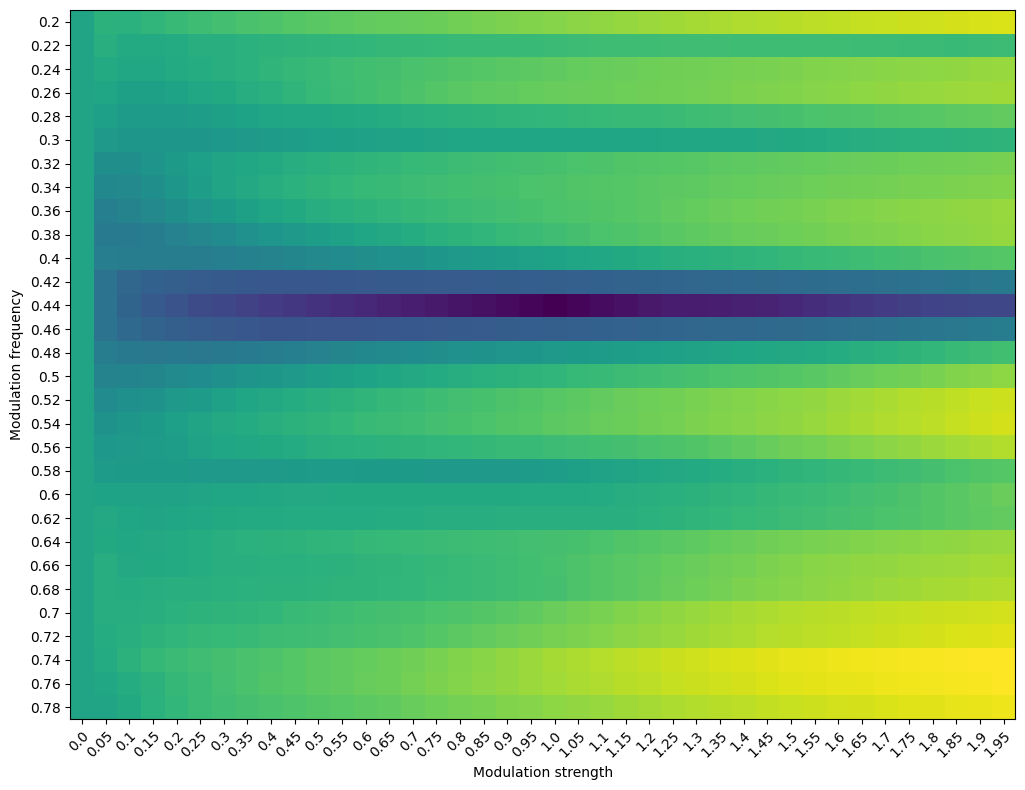

In [35]:
fig, ax = plt.subplots()

im = ax.imshow(results)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")

fig.tight_layout()

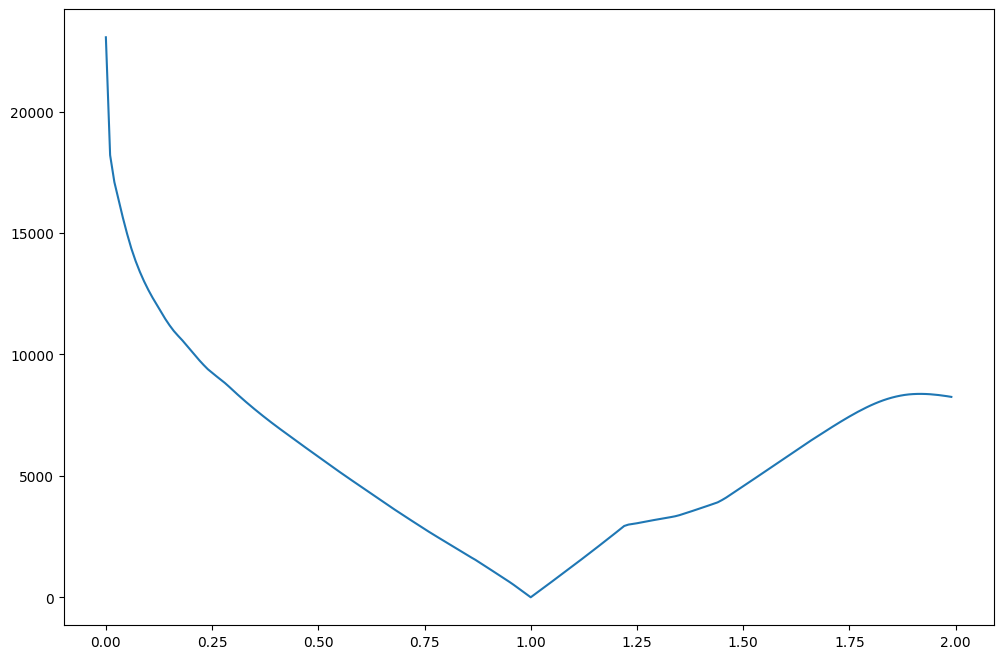

In [23]:
# mod_freqs = [ a/1000 for a in range(400, 600, 40) ]
mod_strengths = [ a / 100 for a in range(0, 200, 1) ]

# mod_freqs = [ 0, 0.1, 0.440, 1.2 ] 
# mod_strengths = [ 1.0 ]
# results = np.zeros((len(mod_freqs), len(mod_strengths)))
results = []

# for freq_index, freq in enumerate(mod_freqs):
for mod_index, mod_strength in enumerate(mod_strengths):
    graph, _, _ = make_simple_fm(.440, mod_strength)
    audio_arr = np.zeros(SAMPLE_RATE * 1)
    for i in range(len(audio_arr)):
        audio_arr[i] = graph.tick()

    generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
    dist, cost, acc_cost, path = dtw(target_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
    # print(freq, mod_strength, ":", dist)

    # results[freq_index][mod_index] = dist
    results.append(dist)
    
plt.plot( mod_strengths, results )

[0.2, 0.202, 0.204, 0.206, 0.208, 0.21, 0.212, 0.214, 0.216, 0.218, 0.22, 0.222, 0.224, 0.226, 0.228, 0.23, 0.232, 0.234, 0.236, 0.238, 0.24, 0.242, 0.244, 0.246, 0.248, 0.25, 0.252, 0.254, 0.256, 0.258, 0.26, 0.262, 0.264, 0.266, 0.268, 0.27, 0.272, 0.274, 0.276, 0.278, 0.28, 0.282, 0.284, 0.286, 0.288, 0.29, 0.292, 0.294, 0.296, 0.298, 0.3, 0.302, 0.304, 0.306, 0.308, 0.31, 0.312, 0.314, 0.316, 0.318, 0.32, 0.322, 0.324, 0.326, 0.328, 0.33, 0.332, 0.334, 0.336, 0.338, 0.34, 0.342, 0.344, 0.346, 0.348, 0.35, 0.352, 0.354, 0.356, 0.358, 0.36, 0.362, 0.364, 0.366, 0.368, 0.37, 0.372, 0.374, 0.376, 0.378, 0.38, 0.382, 0.384, 0.386, 0.388, 0.39, 0.392, 0.394, 0.396, 0.398, 0.4, 0.402, 0.404, 0.406, 0.408, 0.41, 0.412, 0.414, 0.416, 0.418, 0.42, 0.422, 0.424, 0.426, 0.428, 0.43, 0.432, 0.434, 0.436, 0.438, 0.44, 0.442, 0.444, 0.446, 0.448, 0.45, 0.452, 0.454, 0.456, 0.458, 0.46, 0.462, 0.464, 0.466, 0.468, 0.47, 0.472, 0.474, 0.476, 0.478, 0.48, 0.482, 0.484, 0.486, 0.488, 0.49, 0.492, 0.4

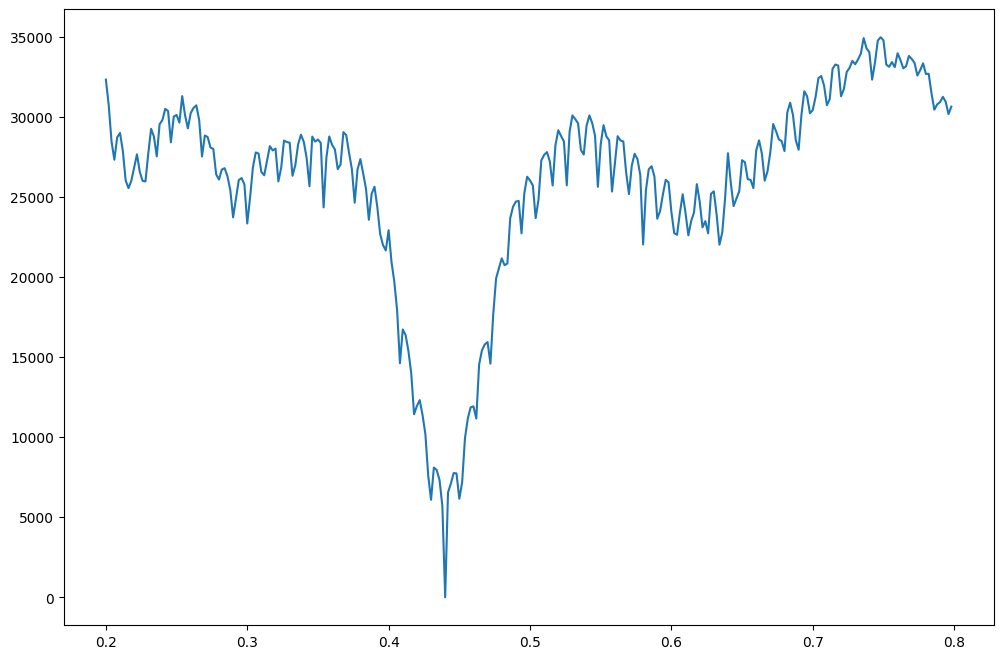

In [29]:
mod_freqs = [ a/1000 for a in range(200, 800, 2) ]
# mod_strengths = [ a / 100 for a in range(0, 200, 1) ]

print(mod_freqs)

# # mod_freqs = [ 0, 0.1, 0.440, 1.2 ] 
# # mod_strengths = [ 1.0 ]
# # results = np.zeros((len(mod_freqs), len(mod_strengths)))
results = []

for freq_index, freq in enumerate(mod_freqs):
# for mod_index, mod_strength in enumerate(mod_strengths):
    graph, _, _ = make_simple_fm(freq, 1.0)
    audio_arr = np.zeros(SAMPLE_RATE * 1)
    for i in range(len(audio_arr)):
        audio_arr[i] = graph.tick()

    generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
    dist, cost, acc_cost, path = dtw(target_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
    # print(freq, mod_strength, ":", dist)

    # results[freq_index][mod_index] = dist
    results.append(dist)
    
plt.plot( mod_freqs, results )

TypeError: Invalid shape (5,) for image data

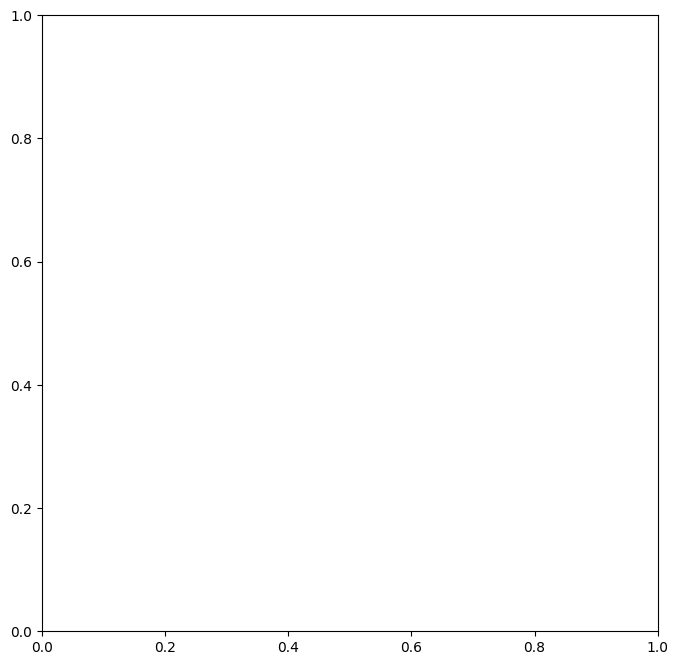

In [13]:
fig, ax = plt.subplots()

im = ax.imshow(results)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")

fig.tight_layout()

In [ ]:
harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()

im = ax.imshow(harvest)